In [1]:
from PIL import Image
from random import randint
import numpy as np
import pandas as pd
import sys
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import torchvision
import warnings
import functools


%matplotlib inline

class datasetFactory(object):

    def __init__(self, IMAGE_SIZE = 416, listOfClasses=["road"]):
        
        try:
            self.IMAGE_SIZE=IMAGE_SIZE
            self.classMap = dict()
            
            if(len(listOfClasses) <= 0):
                #self.classList = ["background","left-shoulder","left-yellow-line-marker","white-lane-markers","lane",
                #         "right-white-line-marker", "right-shoulder"]
                
                self.classList=["road"]
            else: 
                self.classList = listOfClasses
            
            for i in range(0, len(self.classList)):
                self.classMap[self.classList[i]] = i
                               
            self.NUM_CLASSES = len(self.classList)
            
        except IOError:
            print('An error occured trying to read the file.')
            
    
    def drawBackground(self, imgMap):
        
        # choose one color for background
        rgb = (randint(0,255),randint(0,255),randint(0,255))
        
        for i in range(self.IMAGE_SIZE):
            for j in range(self.IMAGE_SIZE):
                #DRAW BACKGROUND
                imgMap[i,j] = rgb
    
    #https://stackoverflow.com/questions/2536307/decorators-in-the-python-standard-lib-deprecated-specifically
        
   
    def computeTensorBackground(self,imgMap,tensorMap):
        # road/background channel
        tensorMap[0] = torch.zeros([self.IMAGE_SIZE, self.IMAGE_SIZE])
        
        # in the background channel, update values to know which are being used in other tensors
        for i in range(1,len(self.classList)):
            tensorMap[0][tensorMap[i] == 1] = -1 
                
        tensorMap[0][tensorMap[0] == 0] = 1
        tensorMap[0][tensorMap[0] == -1] = 0
        
                  
    def drawStraightLine(self,imgMap,start,width,red,redDev,green,greenDev,blue,blueDev,onLen,offLen,
                         class_type_flag,tensorMap):
        if start < 0 or start + width >= self.IMAGE_SIZE:
            print(start,width, "ERROR")
            exit()
            
        class_type_corresponding_channel = self.classMap[class_type_flag]
        #print("DRAW CLASS", class_type_flag)
        
        for i in range(start,start+width):
            on = True
            dist = onLen
            for j in range(self.IMAGE_SIZE):
                if on == True:
                    r = max(0,min(255,int(np.random.normal(red,redDev))))
                    g = max(0,min(255,int(np.random.normal(green,greenDev))))
                    b = max(0,min(255,int(np.random.normal(blue,blueDev))))
                    imgMap[i,j] = (r,g,b)
                    tensorMap[class_type_corresponding_channel, i,j] = 1
                    if onLen > 0:
                        dist = dist - 1
                        if dist < 0:
                           dist = offLen
                           on = not on
                else:
                    dist = dist - 1
                    if dist < 0:
                        dist = onLen
                        on = not on
                        
    def drawWhiteLaneDevisor(self,imgMap,start,width,red,redDev,green,greenDev,blue,blueDev,onLen,offLen,class_type_flag,
                             tensorMap):
        if start < 0 or start + width >= self.IMAGE_SIZE:
            print(start,width, "ERROR")
            exit()
            
        class_type_corresponding_channel = self.classMap[class_type_flag]
        
        for i in range(start,start+width):
            on = True
            dist = onLen
            for j in range(self.IMAGE_SIZE):
                if on == True:
                    r = max(0,min(255,int(np.random.normal(red,redDev))))
                    g = max(0,min(255,int(np.random.normal(green,greenDev))))
                    b = max(0,min(255,int(np.random.normal(blue,blueDev))))
                    imgMap[i,j] = (r,g,b)
                    tensorMap[class_type_corresponding_channel, i,j] = 1
                    if onLen > 0:
                        dist = dist - 1
                        if dist < 0:
                           dist = offLen
                           on = not on
                else:
                    #fill in the image with grey
                    r = max(0,min(255,int(np.random.normal(128,40))))
                    g = max(0,min(255,int(np.random.normal(128,40))))
                    b = max(0,min(255,int(np.random.normal(128,40))))
                    
                    imgMap[i,j] = (r,g,b)
                    tensorMap[class_type_corresponding_channel, i,j] = 1
                    dist = dist - 1
                    if dist < 0:
                        dist = onLen
                        on = not on                    
                        
                
    def generateNewImageWithTensor(self,centerShldrWidth,laneCount,laneWidth,lineWidth,shoulderWidth, tensorMap):
        img = Image.new('RGB',(self.IMAGE_SIZE,self.IMAGE_SIZE))
        imgMap = img.load()
        
        factor = 0.45   # ft/px
        # 0 to 36
        #centerShldrWidth=randint(0,80)
        # 0 to 5
        #laneCount = randint(0,5)
        # 8 to 15
        #laneWidth = randint(17,34) 
        # 4 to 6 in
        #lineWidth = randint(1,2)
        # 8 to 40
        #shoulderWidth=randint(0,89)
        start = (self.IMAGE_SIZE - centerShldrWidth - (laneCount+1)*lineWidth - laneCount * laneWidth - shoulderWidth)//2
        
        if start < 10:
           print(centerShldrWidth,laneCount,laneWidth,lineWidth,shoulderWidth,"EXCEEDED IMAGE_SIZE")
           sys.exit(-1)
            
        #DRAW BACKGROUND
        self.drawBackground(imgMap)

        #DRAW: left shoulder    
        self.drawStraightLine(imgMap,start,centerShldrWidth,128,20,128,20,128,20,0,0, "road",tensorMap)
        
        # move pointer by the shoulder width
        start += centerShldrWidth
        #print("laneCount is:",laneCount)
        
        # for the number of lanes we have, draw them
        for i in range(laneCount):
            #print("printing lane number:",i)
            if i == 0:
                #DRAW left-yellow-line-marker
                self.drawStraightLine(imgMap,start,lineWidth,200,40,200,40,50,40,0,0, "road",tensorMap)
            else:
                #DRAW white-lane-marker
                self.drawWhiteLaneDevisor(imgMap,start,lineWidth,200,40,200,40,200,40,20,20, "road",tensorMap)
            
            #move over a white-lane-markers line
            start += lineWidth 
            
            #DRAW our lane
            self.drawStraightLine(imgMap,start,laneWidth-lineWidth,128,40,128,40,128,40,0,0, "road",tensorMap)
            
            #move pointer by the lane width
            start += laneWidth - lineWidth 
        
        #DRAW white-line-marker
        #self.drawStraightLine(imgMap,start,lineWidth,200,40,400,40,200,40,0,0, "right-white-line-marker")
        self.drawStraightLine(imgMap,start,lineWidth,255,25,255,25,255,25,0,0, "road", tensorMap)
        
        #move pointer by the white-line width
        start += lineWidth
        
        #DRAW right-shoulder
        self.drawStraightLine(imgMap,start,shoulderWidth, 128,40,128,40,128,40,0,0, "road", tensorMap)
        
        #fill in background tensor
        #self.computeTensorBackground(imgMap, tensorMap)
        
        #roadWidth = centerShldrWidth + laneCount*laneWidth + shoulderWidth
        roadWidth = laneCount*laneWidth

        #roadWidth = (roadWidth*factor - self.RdwyWidthMean)/self.RdwyWidthStdDev
        roadWidth = roadWidth*factor
        #laneCount = (laneCount - self.NumLanesMean)/self.NumLanesStdDev
        #shoulderWidth = (shoulderWidth*factor - self.shldrCenterMean)/self.shldrCenterStdDev
        shoulderWidth = shoulderWidth*factor
        #centerShldrWidth = (centerShldrWidth*factor - self.ShldrWidthMean)/self.ShldrWidthStdDev
        centerShldrWidth = centerShldrWidth*factor

        return (roadWidth,laneCount,shoulderWidth,centerShldrWidth),img, tensorMap    
    
    
    
    def showClassLabelOnImage(self, img, tensor, class_label):
        imgTMP = img.copy()
        imgMap = imgTMP.load()
        class_type_corresponding_channel = self.classMap[class_label]
        
        for i in range(0, self.IMAGE_SIZE):
            for j in range(0, self.IMAGE_SIZE):
                if tensor[class_type_corresponding_channel, i,j] == 1:
                    #show class label in black
                    imgMap[i,j] = (0,0,0)
        
        return imgTMP

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#centerShldrWidth,laneCount,laneWidth,lineWidth,shoulderWidth
c = randint(0,80)
lanecount = randint(1,5)
laneWidth = randint(17,35)
lineWidth = randint(1,2)
shoulderWidth = randint(0,89)

In [3]:
new_road_factory = datasetFactory()
test_tensor = torch.zeros(1,416,416)

print(c,lanecount,laneWidth,lineWidth,shoulderWidth)

test_tuple,img,test_tensor = new_road_factory.generateNewImageWithTensor(c,
                                                                         lanecount,
                                                                         laneWidth,
                                                                         lineWidth,
                                                                         shoulderWidth,
                                                                         test_tensor)

torch.save(test_tensor, "/home/peo5032/Desktop/tensor.pt")

51 1 28 2 26


In [4]:
def showInferenceOnImage(img, tensor, class_label, threshold, classMap):
    IMAGE_SIZE = 416
    imgTMP = img.copy()
    imgMap = imgTMP.load()
    class_type_corresponding_channel = classMap[class_label]
    print("index for channel", class_label, ":", class_type_corresponding_channel)    
    for i in range(0, IMAGE_SIZE):
        for j in range(0, IMAGE_SIZE):
            if tensor[class_type_corresponding_channel, i,j] >= threshold:
                #show class label in white
                imgMap[i,j] = (0,0,0)
        
    return imgTMP

def rotationOfImageAndTensor(img, tensor, classList, rotation=0):
    
        img = torchvision.transforms.functional.rotate(img,rotation)

        for i in range(0,len(classList)):
            PIC = torchvision.transforms.ToPILImage(mode='L')(tensor)
            PIC = torchvision.transforms.functional.rotate(PIC,-1 * rotation)
            tensor = torchvision.transforms.functional.to_tensor(PIC)
        return img, tensor

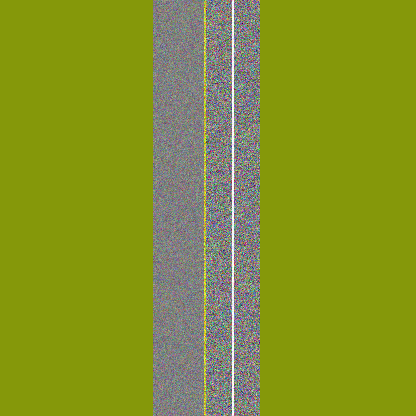

In [5]:
img.save("/home/peo5032/Pictures/TESTER.png")
img

In [6]:
new_road_factory.classList

['road']

index for channel road : 0


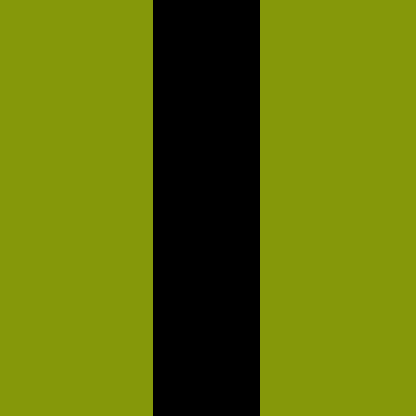

In [7]:
test_tensor = torch.load('/home/peo5032/Desktop/tensor.pt')
showInferenceOnImage(img, test_tensor, "road", 0.6, new_road_factory.classMap)

In [12]:
img, test_tensor = rotationOfImageAndTensor(img, test_tensor, new_road_factory.classList, 135)

index for channel road : 0


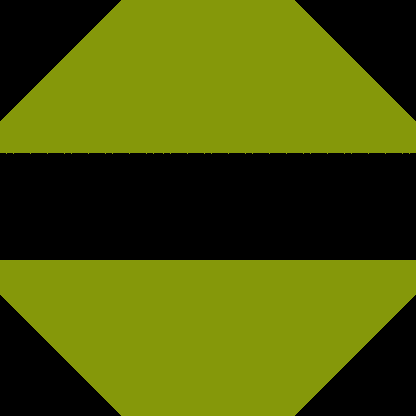

In [15]:
showInferenceOnImage(img, test_tensor, "road", threshold=0.60,classMap=new_road_factory.classMap)